# 股票数据整理（6.7）

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import resample

dt1 = pd.read_csv('股票数据/行情序列2001年周数据.csv')
dt2 = pd.read_csv('股票数据/行情序列2002年周数据.csv')
dt3 = pd.read_csv('股票数据/行情序列2003年周数据.csv')
dt4 = pd.read_csv('股票数据/行情序列2004-5年周数据.csv')
dt5 = pd.read_csv('股票数据/行情序列2006-2009年周数据.csv')
dt6 = pd.read_csv('股票数据/行情序列2010-2013年周数据.csv')
dt7 = pd.read_csv('股票数据/行情序列2014-2018年周数据.csv')

dt = pd.concat([dt1,dt2,dt3,dt4,dt5,dt6,dt7], axis = 0, ignore_index = True)

dt_na = dt.dropna()

dt_na

dt.shape

dt_na.shape

dt_na.to_csv('数据已合并.csv', index = False, encoding='utf_8_sig')

# 数据初步描述分析（6.8）

见【data description script.R】文件

***描述性分析结果*** 
1. 一共截取328只基金的累积净值数据，运营时间最长的基金从周2005/1/7 - 周2018/12/28，包含715个数据点，有85%的基金单支拥有50 ~ 400个数据点, 其中有25.8%的基金单支拥有200~250个数据点。
2. 由04年至18年，每年数据点数量由最初的1个（仅2004/12/31, 上证500ETF一支）至15674个逐年增多。
3. 由04年至18年，基金数量由最初的1支至328支逐年增多，13年基金数量超过100支，14年后基金数量猛增。


# 数据在模型Kosowski、Fama&French的抽样试验（6.9 - 6.15）

In [2]:
# 基金数据导入
funds = pd.read_csv('funds_data.csv')

In [3]:
funds.shape

(68838, 4)

In [4]:
funds.head(5)

,代码,简称,时间,周单位净值(元)
0,160706.OF,嘉实300,2005-09-02,1.007
1,160706.OF,嘉实300,2005-09-09,1.007
2,160706.OF,嘉实300,2005-09-16,1.023
3,160706.OF,嘉实300,2005-09-23,0.971
4,160706.OF,嘉实300,2005-09-30,0.971


In [5]:
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68838 entries, 0 to 68837
Data columns (total 4 columns):
代码          68838 non-null object
简称          68838 non-null object
时间          68838 non-null object
周单位净值(元)    68838 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [6]:
# 基金回报率计算
funds['净回报率'] = funds.groupby('代码')

TypeError: 'generator' object is not callable

In [6]:
# Cahart模型因子数据导入
cahart = pd.read_csv('fivefactor_weekly.csv')

In [7]:
cahart.shape

(1372, 13)

In [8]:
cahart.head(5)

,trdwk,mkt_rf,smb,hml,umd,rf,smb_equal,hml_equal,umd_equal,rmw,cma,rmw_equal,cma_equal
0,1994-01-14,-0.049785,-0.010605,-0.001557,0.012826,0.002005,-0.006920,0.007555,0.010533,0.010301,-0.022515,0.001189,-0.019500
1,1994-01-21,-0.040166,0.024709,0.006786,0.034309,0.002005,0.018672,0.004249,0.023625,-0.023659,-0.015334,-0.023030,-0.000086
2,1994-01-28,-0.058775,0.023957,0.032066,-0.033173,0.002005,0.027413,0.025122,-0.024170,-0.031257,-0.035271,-0.024394,-0.017531
3,1994-02-04,0.063141,-0.030274,-0.053609,0.008469,0.002005,-0.037995,-0.052423,-0.003859,0.070407,0.031119,0.068059,0.005449
4,1994-02-18,-0.100108,0.034504,0.044310,0.002641,0.002005,0.033935,0.033539,0.008561,-0.074498,-0.036797,-0.051754,-0.007289


In [9]:
cahart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 13 columns):
trdwk        1372 non-null object
mkt_rf       1372 non-null float64
smb          1372 non-null float64
hml          1372 non-null float64
umd          1372 non-null float64
rf           1372 non-null float64
smb_equal    1372 non-null float64
hml_equal    1372 non-null float64
umd_equal    1372 non-null float64
rmw          1372 non-null float64
cma          1372 non-null float64
rmw_equal    1372 non-null float64
cma_equal    1372 non-null float64
dtypes: float64(12), object(1)
memory usage: 139.4+ KB


In [10]:
# 时间类数据格式调整
funds['时间'] = pd.to_datetime(funds['时间'], format='%Y-%m-%d')
cahart['trdwk'] = pd.to_datetime(cahart['trdwk'], format='%Y-%m-%d')

## Kosowaski模型（6.9 - 6.11）

### 1、构建残差population

按照Kosowaski模型，根据Cahart四因子模型构建各基金alpha, 周因子数据由国泰安数据库提供。

##### 对齐四因子与基金周收益时间点
取四因子及最长运营的基金周收益05/01/07 - 18/12/28数据进行right_join, 结果如下；

***观察结果***：周因子数据与单支基金周净值数据存在差值，周因子数据缺失2006/10/6、2007/10/5、2009/12/31、2013/12/31四周数据，为计算alpha、载荷及残差用缺失值上值进行填补。
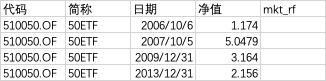

#### 合并四因子与基金收益率

In [11]:
# 取Cahart模型所需因子：市场风险因子（mkt_rf）、规模风险因子（smb）、账面市值比风险因子（hml）、惯性/动量因子（umd）及无风险利率（rf）
c1 = cahart[(cahart['trdwk']>="2005-01-07")&(cahart['trdwk']<="2018-12-28")]
c2 = c1[['trdwk','mkt_rf','smb','hml','umd','rf']]
# 取基金净值有效时间段内数据
f = funds[(funds['时间']>='2005-01-07')&(funds['时间']<='2018-12-28')]
f = f.rename(columns = {'时间': 'trdwk'})
# 合并因子与基金净值
cmodel = pd.merge(f, c2, how='left', on='trdwk')

In [12]:
# 处理缺失值： 用上一个非缺失值填补
cmodel = cmodel.fillna(method='ffill')

In [13]:
# 调整合并后数据列名
cmodel = cmodel.rename(columns = {'代码': 'code', '简称': 'name', '周累计净值(元)': 'netvalue'})

In [14]:
cmodel.shape

(68509, 9)

In [15]:
cmodel.head(5)

,code,name,trdwk,netvalue,mkt_rf,smb,hml,umd,rf
0,510050.OF,50ETF,2005-01-07,0.981,-0.009569,0.016692,-0.001600,-0.026043,0.000428
1,510050.OF,50ETF,2005-01-14,0.983,0.002330,0.006033,0.002732,-0.003396,0.000428
2,510050.OF,50ETF,2005-01-21,0.988,-0.008801,0.004323,0.002299,-0.018932,0.000428
3,510050.OF,50ETF,2005-01-28,0.976,-0.022081,-0.017804,-0.002866,0.034744,0.000428
4,510050.OF,50ETF,2005-02-04,0.873,0.027939,-0.046164,0.001879,0.039884,0.000428


In [16]:
# 查看净值与四因子之间相关性
corr_dt = cmodel[3:]

In [17]:
corr_dt.corr()

,netvalue,mkt_rf,smb,hml,umd,rf
netvalue,1.000000,0.051949,0.015082,-0.010440,-0.009268,-0.026572
mkt_rf,0.051949,1.000000,0.393862,-0.195522,0.087409,0.056437
smb,0.015082,0.393862,1.000000,-0.525071,-0.106395,0.077798
hml,-0.010440,-0.195522,-0.525071,1.000000,-0.066269,-0.043882
umd,-0.009268,0.087409,-0.106395,-0.066269,1.000000,-0.011658
rf,-0.026572,0.056437,0.077798,-0.043882,-0.011658,1.000000


#### 建立OLS回归模型

根据论文描述，Kosowaski模型是对单支基金先OLS回归得到残差，再对单支基金的残差pop进行bootstrap抽样，一次bootstrap抽样能得到一组残差样本，在计算出一组伪净值数据，根据一组伪净值数据用OLS回归计算出一个伪alpha。

bootstrap对单支基金抽样b次能得到b个伪alpha，抽样n个基金能构成一个n乘以b的alpha分布。

In [18]:
funds_list = cmodel.code.unique() # 基金清单

In [19]:
# 多基金残差计算
def res_caculator(f):
    result = sm.OLS(f['netvalue'], sm.add_constant(f.loc[:, ['mkt_rf', 'smb', 'hml', 'umd']])).fit() # 净值根据Cahart四因子做线性回归
    nv_dot = result.fittedvalues # 线性方程拟合后计算净值预测值
    res = f.netvalue - nv_dot # 净值与净值预测值相减形成残差
    
    # 记录回归方程中各参数取值
    coef = {}
    coef.update(alpha_dot = result.params[0], mkt_b = result.params[1], smb_b = result.params[2], hml_b = result.params[3],  umd_b = result.params[4])
    
    # 返回res计算后的单支基金数据及对应的四因子回归方程系数
    return (res, coef) 

In [72]:
funds1 = cmodel[cmodel['code'] == funds_list[0]].reset_index(drop=True) # 使用基金清单中第一支基金测试以上残差计算函数
plt1 = res_caculator(funds1)[0]
coefs = res_caculator(funds1)[1]

In [73]:
plt1_k_sample = k_sampling(plt1)
plt1_k_sample.shape

(715,)

/Users/xurui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


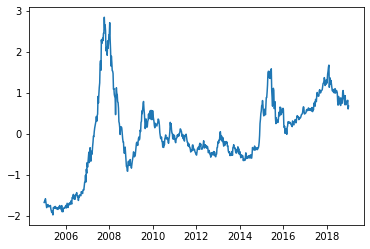

In [22]:
fig = plt.figure()  # 残差计算结果，表现出四因子估计值与基金真是净值时序之间的关系 
ax = fig.add_subplot(111)
funds1.loc[:,'res'] = plt1
ax.plot(funds1.trdwk, funds1.res)

# **** 残差广泛分布在[-2, 3]之间，整体对0的偏离程度较大，说明线性回归的效果不太好 **** #

### 2. 构建残差抽样模型

对残差数列进行有放回抽样

In [23]:
# kosowski模型针对残差的Bootstrap抽样（******* 抽样部分之后要加入最优时序分块和家族分块步骤 ********）
def k_sampling(res):
    # 残余抽样
    n = len(res)
    spl_res = resample(res, n_samples = n, replace = 1)
    
    return spl_res

### 3. 计算运气Alpha分布 （6.15）

根据单次残差抽样样本可得到单次伪回报序列，对单次伪回报序列做OLS回归可得到单次alpha值

#### 构建伪Alpha计算方程

In [151]:
# kosowski模型抽样残差进行伪回报及伪alpha计算
def k_fake_alpha_calculator(res, coef, cahart_fact   ors):
    res = res.reset_index(drop=True)
    
    fake_nv = cahart_factors['mkt_rf']*coef.get('mkt_b') + cahart_factors['smb']*coef.get('smb_b') + \
                   cahart_factors['hml']*coef.get('hml_b') + cahart_factors['umd']*coef.get('umd_b') + res
    
    fake_result = sm.OLS(fake_nv, sm.add_constant(cahart_factors.loc[:, 'mkt_rf':'umd'])).fit()
    fake_alpha = fake_result.params[0]
    
    return fake_alpha

In [153]:
k_fake_alpha_calculator(plt1_k_sample, coefs, funds1)

0.021324047693391905

#### 遍历基金计算运气alpha，得到运气alpha分布 *** 算力不足 该部分目前耗时30 - 40min ***

！***之后不一定遍历所有基金 思路待清晰***

In [170]:
fake_alpha_onefirm = []
for fund in funds_list: # 遍历基金库中所有基金
    
    tmp_f = cmodel[cmodel['code'] == fund].reset_index(drop=True)
    tmp_res = res_caculator(tmp_f) # 计算单支基金四因子回归模型的残余
    
    tmp_cahart = tmp_f.loc[:, 'mkt_rf':'umd']   # 当前基金对应的Cahart四因子数据
    coef = tmp_res[1] # 当前基金Cahart OLS回归后各因子参数
    
    for b in range(1000): # 重复Bootstrap抽样1000次

        bootstrap_res = k_sampling(tmp_res[0]) #  当前基金残余Bootstrap抽样
        fk_alpha = k_fake_alpha_calculator(bootstrap_res, coef, tmp_cahart) #  计算单次抽样res产生的伪净值序列
    
        fake_alpha_onefirm.append(fk_alpha)

In [173]:
print(len(fake_alpha_onefirm))
fake_alpha_onefirm[:5]

328000


[-0.013140322366647278,
 0.05420911516577731,
 -0.06360524128133935,
 0.05456302606986957,
 0.012352930995006482]

(array([2.20000e+01, 1.45000e+02, 1.42700e+03, 1.78250e+04, 2.10293e+05,
        9.12240e+04, 6.31200e+03, 6.54000e+02, 8.80000e+01, 1.00000e+01]),
 array([-0.12029401, -0.0952312 , -0.0701684 , -0.04510559, -0.02004278,
         0.00502002,  0.03008283,  0.05514564,  0.08020844,  0.10527125,
         0.13033405]),
 <a list of 10 Patch objects>)

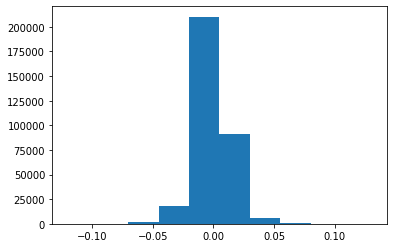

In [174]:
fig = plt.figure()  
ax = fig.add_subplot(111)
ax.hist(fake_alpha_onefirm)

## Fama&French模型 （6.15）